In [1]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

def vgg16_model(trainable=True):
    base_model = VGG16(False, "imagenet")
    train_from_layer = -2
    for layer in base_model.layers[:train_from_layer]:
        layer.trainable = False
        print("{} is not trainable".format(layer.name))
    for layer in base_model.layers[train_from_layer:]:
        layer.trainable = True
        print("{} is trainable".format(layer.name))
    last_conv_layer = base_model.get_layer("block5_conv3")
    x = GlobalAveragePooling2D()(last_conv_layer.output)
    x = Dense(512, activation="relu")(x)
    predictions = Dense(1, activation="sigmoid")(x)
    return Model(base_model.input, predictions)



model = vgg16_model(False)
model.summary()

Using TensorFlow backend.


input_1 is not trainable
block1_conv1 is not trainable
block1_conv2 is not trainable
block1_pool is not trainable
block2_conv1 is not trainable
block2_conv2 is not trainable
block2_pool is not trainable
block3_conv1 is not trainable
block3_conv2 is not trainable
block3_conv3 is not trainable
block3_pool is not trainable
block4_conv1 is not trainable
block4_conv2 is not trainable
block4_conv3 is not trainable
block4_pool is not trainable
block5_conv1 is not trainable
block5_conv2 is not trainable
block5_conv3 is trainable
block5_pool is trainable
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64) 

In [2]:
from Datasets import Datasets

dataset_name = "Bradbury"
dataset = Datasets.datasets()[dataset_name]

In [3]:
from keras.applications.xception import preprocess_input
import numpy as np

# Add preprocessing
train_images = dataset[0].images
train_labels  = dataset[0].labels

test_images = dataset[1].images
test_labels = dataset[1].labels

validation_images = dataset[2].images
validation_labels = dataset[2].labels

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from ProjectPaths import ProjectPaths

In [107]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.5,                               
    horizontal_flip=True)

test_datagen = ImageDataGenerator()


In [108]:
from PerformanceMetrics import PerformanceMetrics

model.compile(optimizer="rmsprop", loss='binary_crossentropy',
                  metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [109]:
batch_size = 64

train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [110]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping


epochs = 100

model_name = "vgg16_3t_wmp_wr_{}".format(dataset_name)

checkpoint_dir = ProjectPaths.instance().checkpoint_dir_for(model_name, batch_size, epochs)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

file_in_checkpoint_dir = ProjectPaths.instance().file_in_checkpoint_dir(model_name, batch_size,
                                                                 epochs,  model_name +
                                                                 "__{epoch:02d}_{val_acc:.2f}.hdf5")

early_stopping_callback = EarlyStopping(patience=10)
model_checkpoint_callback = ModelCheckpoint(file_in_checkpoint_dir, monitor='val_acc', verbose=True,
                                                save_weights_only=True,
                                                save_best_only=True)

log_dir = os.path.join(ProjectPaths.instance().log_dir, model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=False, write_images=False)


model.fit_generator(train_generator,
                    steps_per_epoch=len(train_labels) // batch_size, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
                    validation_data=test_generator,
                    validation_steps=len(test_labels))

Epoch 1/100
56/56 [==============================] - 3s 56ms/step - loss: 0.2487 - acc: 0.8984 - precision: 0.8881 - recall: 0.9142 - fmeasure: 0.8984 - val_loss: 0.1811 - val_acc: 0.9227 - val_precision: 0.8776 - val_recall: 0.9825 - val_fmeasure: 0.9252

Epoch 00001: val_acc improved from -inf to 0.92270, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_Bradbury_2018-12-05_64_100/vgg16_3t_wmp_wr_Bradbury__01_0.92.hdf5
Epoch 2/100
56/56 [==============================] - 3s 56ms/step - loss: 0.2473 - acc: 0.9029 - precision: 0.8865 - recall: 0.9251 - fmeasure: 0.9039 - val_loss: 0.2048 - val_acc: 0.9149 - val_precision: 0.8599 - val_recall: 0.9904 - val_fmeasure: 0.9189

Epoch 00002: val_acc did not improve from 0.92270
Epoch 3/100
56/56 [==============================] - 3s 56ms/step - loss: 0.2512 - acc: 0.9025 - precision: 0.8874 - recall: 0.9247 - fmeasure: 0.9038 - val_loss: 0.1818 - val_acc: 0.9227 - val_precision: 0.8724 - val_recall: 0.9904 - val_fme

In [111]:
import pandas as pd

train_eval = model.evaluate(train_images, train_labels, batch_size)
test_eval = model.evaluate(test_images, test_labels, batch_size)
validation_eval = model.evaluate(validation_images, validation_labels, batch_size)

np_model_evaluations = np.array([train_eval, test_eval, validation_eval])

evaluations = pd.DataFrame(np_model_evaluations, columns=model.metrics_names)
print(evaluations.head())

1022/1022 [==============================] - 0s 399us/step
       loss       acc  precision    recall  fmeasure
0  0.131101  0.947065   0.919650  0.980810  0.948662
1  0.189110  0.924658   0.873249  0.990414  0.927034
2  0.164832  0.934442   0.903623  0.977259  0.938030


In [112]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
   """ Find the optimal probability cutoff point for a classification model related to event rate
   Parameters
   ----------
   target : Matrix with dependent or target data, where rows are observations

   predicted : Matrix with predicted data, where rows are observations

   Returns
   -------
   list type, with optimal cutoff value

   """
   fpr, tpr, threshold = roc_curve(target, predicted)
   i = np.arange(len(tpr))
   roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

   return list(roc_t['threshold'])

In [113]:
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_images, batch_size)

In [114]:
cut_off = find_optimal_cutoff(test_labels, test_predictions)
cut_off

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.797797679901123]

In [115]:
predicted_labels = test_predictions > cut_off
confusion_matrix(test_labels, predicted_labels)


array([[481,  37],
       [ 38, 466]])

In [116]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93       518
          1       0.93      0.92      0.93       504

avg / total       0.93      0.93      0.93      1022



# Aachen

In [117]:
ac_dataset = Datasets.datasets()["AcMüDüHo"]

train_images = ac_dataset[0].images
train_labels = ac_dataset[0].labels

test_images = ac_dataset[1].images
test_labels = ac_dataset[1].labels

validation_images = ac_dataset[2].images
validation_labels = ac_dataset[2].labels

eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(eval_images.shape, eval_labels.shape)

(3357, 75, 75, 3) (374, 75, 75, 3) (934, 75, 75, 3)
(4665, 75, 75, 3) (4665,)


In [118]:
eval_predictions = model.predict(eval_images, batch_size) > cut_off
confusion_matrix(eval_labels, eval_predictions)

array([[1930,  404],
       [ 515, 1816]])

In [119]:
from sklearn.metrics import classification_report

print(classification_report(eval_labels, eval_predictions))

             precision    recall  f1-score   support

        0.0       0.79      0.83      0.81      2334
        1.0       0.82      0.78      0.80      2331

avg / total       0.80      0.80      0.80      4665



# Fresno

In [120]:
fresno_dataset = Datasets.datasets()["Fresno"]

train_images = fresno_dataset[0].images
train_labels = fresno_dataset[0].labels

test_images = fresno_dataset[1].images
test_labels = fresno_dataset[1].labels

validation_images = fresno_dataset[2].images
validation_labels = fresno_dataset[2].labels

fresno_eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
fresno_eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(fresno_eval_images.shape, fresno_eval_labels.shape)

(3646, 75, 75, 3) (1022, 75, 75, 3) (1022, 75, 75, 3)
(5690, 75, 75, 3) (5690,)


In [121]:
fresno_eval_predictions = model.predict(fresno_eval_images, batch_size) > cut_off
confusion_matrix(fresno_eval_labels, fresno_eval_predictions)

array([[2717,  128],
       [ 201, 2644]])

In [122]:
from sklearn.metrics import classification_report

print(classification_report(fresno_eval_labels, fresno_eval_predictions))

             precision    recall  f1-score   support

          0       0.93      0.96      0.94      2845
          1       0.95      0.93      0.94      2845

avg / total       0.94      0.94      0.94      5690



# Heerlen Preprocessing

Now we use the trained model to preprocess the images from Heerlen and see how well it performs.

In [123]:
heerlen_dir = os.path.join(ProjectPaths.instance().image_dir, "Heerlen75x75")
image_files = [os.path.join(heerlen_dir, filename) for filename in os.listdir(heerlen_dir) if filename.endswith("rgb_2016.tiff") or filename.endswith("rgb_2017.tiff")]
image_files = sorted(image_files)
image_files[0:10]

['/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/00071b0a-e436-441d-9739-9911833434aa_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/000fac0e-c102-4af4-8314-d3f53016d465_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/001707ad-b863-480e-8aa9-061b151ae49f_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/001ee372-4d98-406e-81fb-b07711f14887_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0021b36e-80c2-4bc8-ad88-7fcd6290f757_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0025fd83-1c7f-4154-9e88-6c321a41466d_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/002f4183-23f7-49a0-9a04-414adf0ba3cf_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/00304bff-a225-42bd-a269-e38331a21aa1_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0031b200-bb4d-4af0-9738-c816f1c03a27_rgb_2017

In [124]:
len(image_files)

10606

In [125]:
def create_dir(path):
    if os.path.exists(path):
        return
    os.makedirs(path)

In [131]:
preprocessed_dir = os.path.join(ProjectPaths.instance().image_dir, "Heerlen75x75_preprocessed")
positives_dir = os.path.join(preprocessed_dir, "Positives")
negatives_dir = os.path.join(preprocessed_dir, "Negatives")

create_dir(positives_dir)
create_dir(negatives_dir)


In [127]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

def prepare_image(filename):
    img = load_img(filename) 
    img_array = img_to_array(img)
    return img_array[:,:, ::-1]

def image_generator(image_files, batch_size):
    batch = []
    for i, filename in enumerate(image_files):
        if i > 0 and (i % batch_size == 0):
            old_batch = batch
            batch = []
            yield np.array(old_batch)
        batch.append(prepare_image(filename))
    #if len(batch) > 0:
    #    repeat_last = len(batch) - batch_size
    #    repeated_images = [batch[-1] for i in range(repeat_last)]
    #   yield np.array(batch + repeated_images)

heerlen_image_generator = image_generator(image_files, batch_size)

Predict labels for the images in the source directory and write them to positive or negative directory based on the prediction

In [128]:
predictions = model.predict_generator(heerlen_image_generator, steps=len(image_files) // batch_size)
predictions

array([[ 0.],
       [ 1.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [129]:
predictions = predictions.reshape(predictions.shape[0])
predictions.shape

(10560,)

In [132]:
from shutil import copyfile

for i, file_path in enumerate(image_files):        
    filename = os.path.basename(file_path)
    if i >= predictions.shape[0]:
        break
    
    prediction = predictions[i]    
    if prediction > cut_off:
        output_path = os.path.join(positives_dir, filename)
    else:        
        output_path = os.path.join(negatives_dir, filename)
    copyfile(file_path, output_path)

In [133]:
len(os.listdir(positives_dir)), len(os.listdir(negatives_dir))

(4958, 5602)

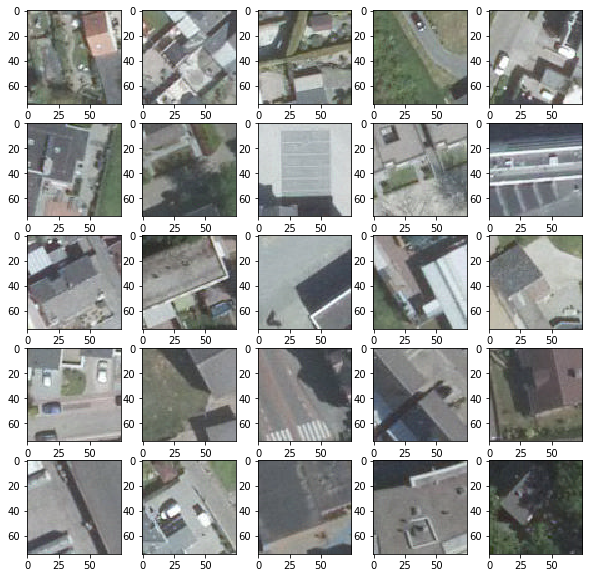

In [134]:
positive_images = [load_img(os.path.join(positives_dir, image)) for i, image in enumerate(os.listdir(positives_dir)) if i < 25]

_, ax = plt.subplots(5,5, figsize=(10,10))

j = 0
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(positive_images[j])     
        j += 1 


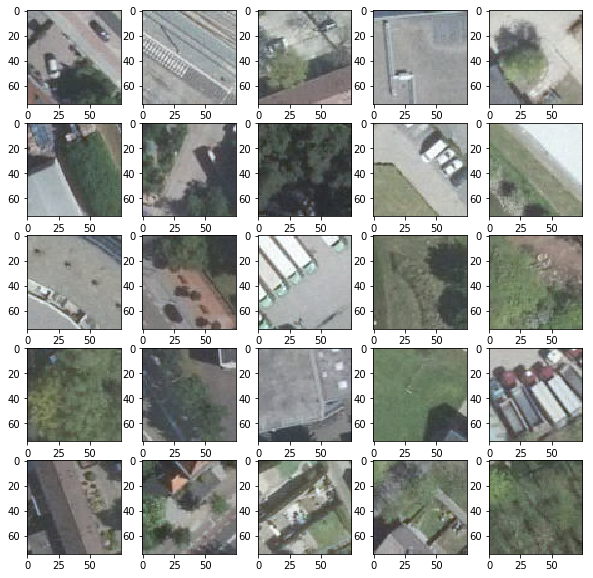

In [135]:
negative_images = [load_img(os.path.join(negatives_dir, image)) for i, image in enumerate(os.listdir(negatives_dir)) if i < 25]

_, ax = plt.subplots(5,5, figsize=(10,10))

j = 0
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(negative_images[j])     
        j += 1 
